# Importing Libraries

In [173]:
import math

import keras
import numpy as np
import pandas as pd
from keras import layers
from keras.models import Functional
from keras.saving.saving_api import load_model
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint, TensorBoard
import absl.logging
from keras.initializers.initializers import RandomUniform
from keras.constraints import NonNeg
from sklearn.metrics import roc_curve

In [174]:
# disable warnings
absl.logging.set_verbosity(absl.logging.ERROR)

## Variables

In [175]:
"""
-------------------------------------------Variables--------------------------------
"""
# -------- Pandas Dataframe
df = pd.read_csv("dataset/UNSW_2018_IoT_Botnet_Full5pc_4.csv")
# df.drop(columns = ['dport','sport'],inplace = True)
# columns
columns = df.columns.tolist()

# categorized columns`
nominal = [col for col in columns if df[col].dtype == 'object']
discrete = [col for col in columns if df[col].dtype == 'int64']
continuous = [col for col in columns if df[col].dtype == 'float']

# categorized dataframe
df_nominal = df.select_dtypes(include=['object'])
df_discrete = df.select_dtypes(include=['int64'])
df_continuous = df.select_dtypes(include=['float'])

#------------- enumerate nominal categories using integers
df_categorical = df.select_dtypes(include=['int8', 'int16'])

# -------- Balanced subset
df_class_0 = df[df['attack'] == 0]
df_class_1 = df[df['attack'] == 1]
df_class_1_subset = df_class_1.sample(n=447, random_state=100)
df_balanced=pd.concat([df_class_1_subset, df_class_0])

C:\Users\faiza\AppData\Local\Temp\ipykernel_1488\2729474595.py:5: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("dataset/UNSW_2018_IoT_Botnet_Full5pc_4.csv")


## Explore

In [176]:
print(df.info())
print(df_class_1.shape)
print(df_class_0.shape)
print(df_class_1_subset.shape)
print(df_balanced.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668522 entries, 0 to 668521
Data columns (total 46 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   pkSeqID                           668522 non-null  int64  
 1   stime                             668522 non-null  float64
 2   flgs                              668522 non-null  object 
 3   flgs_number                       668522 non-null  int64  
 4   proto                             668522 non-null  object 
 5   proto_number                      668522 non-null  int64  
 6   saddr                             668522 non-null  object 
 7   sport                             668522 non-null  object 
 8   daddr                             668522 non-null  object 
 9   dport                             668522 non-null  object 
 10  pkts                              668522 non-null  int64  
 11  bytes                             668522 non-null  i

In [177]:
for col in df:
    print(df[col].value_counts(), '\n')

pkSeqID
3000001    1
3445695    1
3445677    1
3445678    1
3445679    1
          ..
3222843    1
3222844    1
3222845    1
3222846    1
3668522    1
Name: count, Length: 668522, dtype: int64 

stime
1.528099e+09    29
1.528099e+09    28
1.528099e+09    28
1.528099e+09    27
1.528099e+09    27
                ..
1.526345e+09     1
1.526345e+09     1
1.526345e+09     1
1.526345e+09     1
1.529381e+09     1
Name: count, Length: 88102, dtype: int64 

flgs
e        654807
eU        11159
e s        2331
e d         113
e g          99
e &           5
e   t         4
e *           3
e  D          1
Name: count, dtype: int64 

flgs_number
1    654807
6     11159
2      2331
3       113
5        99
7         5
8         4
4         3
9         1
Name: count, dtype: int64 

proto
udp          592145
tcp           67202
icmp           9030
arp             137
ipv6-icmp         8
Name: count, dtype: int64 

proto_number
3    592145
1     67202
4      9030
2       137
5         8
Name: count, dt

## Transform Data

### Enumerate nominal columns

In [178]:
le = LabelEncoder()
for _col in nominal:
    print(f'before enumerating: {_col}', df[_col].value_counts(), '\n', sep='\n')
    try:
        df[_col] = le.fit_transform(df[_col])
    except TypeError:
        df[_col] = le.fit_transform(df[_col].astype(str))
    print(f'after enumerating: {_col}', df[_col].value_counts(), '\n',  sep='\n')

before enumerating: flgs
flgs
e        654807
eU        11159
e s        2331
e d         113
e g          99
e &           5
e   t         4
e *           3
e  D          1
Name: count, dtype: int64


after enumerating: flgs
flgs
0    654807
8     11159
7      2331
5       113
6        99
3         5
1         4
4         3
2         1
Name: count, dtype: int64


before enumerating: proto
proto
udp          592145
tcp           67202
icmp           9030
arp             137
ipv6-icmp         8
Name: count, dtype: int64


after enumerating: proto
proto
4    592145
3     67202
1      9030
0       137
2         8
Name: count, dtype: int64


before enumerating: saddr
saddr
192.168.100.147              182905
192.168.100.148              167582
192.168.100.150              161085
192.168.100.149              147091
192.168.100.5                  5029
192.168.100.3                  4673
192.168.100.6                    38
192.168.100.7                    30
192.168.100.4                    1

In [179]:
scaler = MinMaxScaler()
df.drop(columns = ['attack'], inplace = True)
df = scaler.fit_transform(df)

#### Split Data

In [180]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, df,test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (534817, 45) (534817, 45)
Testing set shape: (133705, 45) (133705, 45)


In [181]:
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)

Feature Correlation

In [182]:
import numpy as np

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(X_train.T)
pd.DataFrame(correlation_matrix).describe()

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,...,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,-0.083873,0.160068,-0.023471,-0.015943,0.156352,0.125683,-0.048550,0.024958,0.004625,0.148617,...,0.004295,-0.023568,0.071017,0.060053,0.029397,0.028494,0.265708,0.262551,-0.165826,0.143297
std,0.325837,0.476675,0.270696,0.268180,0.402146,0.389544,0.235344,0.157200,0.212609,0.408562,...,0.219740,0.290886,0.303779,0.220786,0.241589,0.255595,0.372682,0.361823,0.481195,0.455624
min,-0.594169,-0.987137,-0.378875,-0.375058,-0.878776,-0.765899,-0.462912,-0.094445,-0.340872,-0.801833,...,-0.229890,-0.415692,-0.452273,-0.323878,-0.189651,-0.199348,-0.417826,-0.434333,-0.987137,-0.931116
25%,-0.278736,-0.169387,-0.173208,-0.162465,-0.011703,-0.049295,-0.169387,-0.023050,-0.094579,-0.099114,...,-0.110251,-0.199041,-0.064553,-0.043964,-0.088190,-0.094145,-0.081906,-0.079769,-0.459099,-0.137850
50%,-0.004814,0.004237,-0.007868,0.000195,0.066004,0.008292,0.006617,0.003601,0.004362,0.014679,...,-0.005988,-0.010829,-0.023392,-0.010750,-0.004698,-0.004956,0.313636,0.339807,-0.014187,-0.019144
75%,0.105573,0.478915,0.006803,0.023474,0.409779,0.348787,0.021442,0.012937,0.067822,0.418333,...,0.042963,0.075269,0.216163,0.172998,0.020644,0.024298,0.541690,0.557196,0.162016,0.429364
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [183]:
#input layer
input_dim = 45

# latent space
latent_dim = 30

# output layer
output_dim = 45

_input = keras.Input(shape=(input_dim,))
latent = layers.Dense(latent_dim, activation='relu', kernel_constraint = NonNeg(), bias_constraint=NonNeg())(_input)
output = layers.Dense(output_dim, activation='relu', kernel_constraint = NonNeg(), bias_constraint=NonNeg())(latent)

# this model maps an input to its reconstruction
SAE_model = keras.Model(_input, output)

SAE_model.compile(optimizer='RMSprop', loss='mse')

# callback functions
checkpointer = ModelCheckpoint(filepath=f"SAE_mode",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(histogram_freq=0,
                          write_graph=True,
                          write_images=True)

# train the autoencoder
history = SAE_model.fit(X_train, X_train,
                        epochs=5,
                        batch_size=64,
                        shuffle= True,
                        validation_data=(X_val, X_val),
                        callbacks=[checkpointer, tensorboard]).history

# load the model
autoencoder = load_model('SAE_mode')
weights = autoencoder.get_weights()

Epoch 1/5
6682/6686 [============================>.] - ETA: 0s - loss: 0.0109INFO:tensorflow:Assets written to: SAE_mode\assets


INFO:tensorflow:Assets written to: SAE_mode\assets


6686/6686 [==============================] - 9s 1ms/step - loss: 0.0109 - val_loss: 3.0662e-04
Epoch 2/5
6681/6686 [============================>.] - ETA: 0s - loss: 2.2836e-04INFO:tensorflow:Assets written to: SAE_mode\assets


INFO:tensorflow:Assets written to: SAE_mode\assets


6686/6686 [==============================] - 11s 2ms/step - loss: 2.2833e-04 - val_loss: 1.8623e-04
Epoch 3/5
6681/6686 [============================>.] - ETA: 0s - loss: 1.6664e-04INFO:tensorflow:Assets written to: SAE_mode\assets


INFO:tensorflow:Assets written to: SAE_mode\assets


6686/6686 [==============================] - 9s 1ms/step - loss: 1.6660e-04 - val_loss: 1.7275e-04
Epoch 4/5
6686/6686 [==============================] - 8s 1ms/step - loss: 1.5982e-04 - val_loss: 1.8592e-04
Epoch 5/5
6677/6686 [============================>.] - ETA: 0s - loss: 1.5239e-04INFO:tensorflow:Assets written to: SAE_mode\assets


INFO:tensorflow:Assets written to: SAE_mode\assets


6686/6686 [==============================] - 9s 1ms/step - loss: 1.5235e-04 - val_loss: 1.6869e-04


In [184]:
x_hat = SAE_model.predict(X_test)
mse = np.mean(np.power(X_test - x_hat, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse})
error_df

4179/4179 [==============================] - 4s 899us/step


,Reconstruction_error
0,0.000071
1,0.000016
2,0.000020
3,0.000032
4,0.000024
...,...
133700,0.000074
133701,0.000205
133702,0.000074
133703,0.000015


In [185]:
average_reconstruction_error = sum(mse)/len(mse)
average_reconstruction_error

0.00016293350515100233

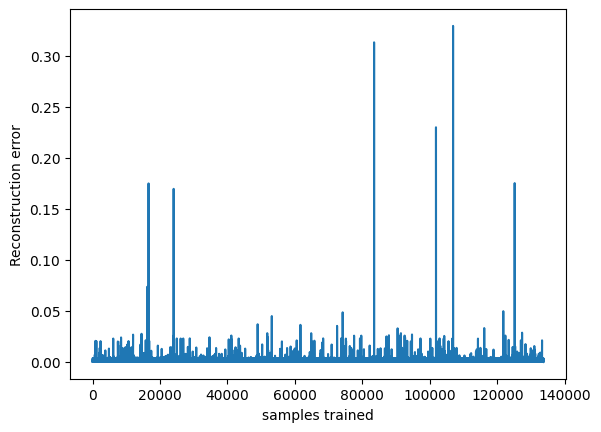

In [186]:
plt.plot(error_df.Reconstruction_error)
plt.xlabel('samples trained')
plt.ylabel('Reconstruction error')
plt.show()

In [187]:
mse_df = pd.DataFrame(mse)
mse_df.describe()

,0
count,133705.000000
mean,0.000163
std,0.001835
min,0.000009
25%,0.000017
50%,0.000023
75%,0.000033
max,0.329614


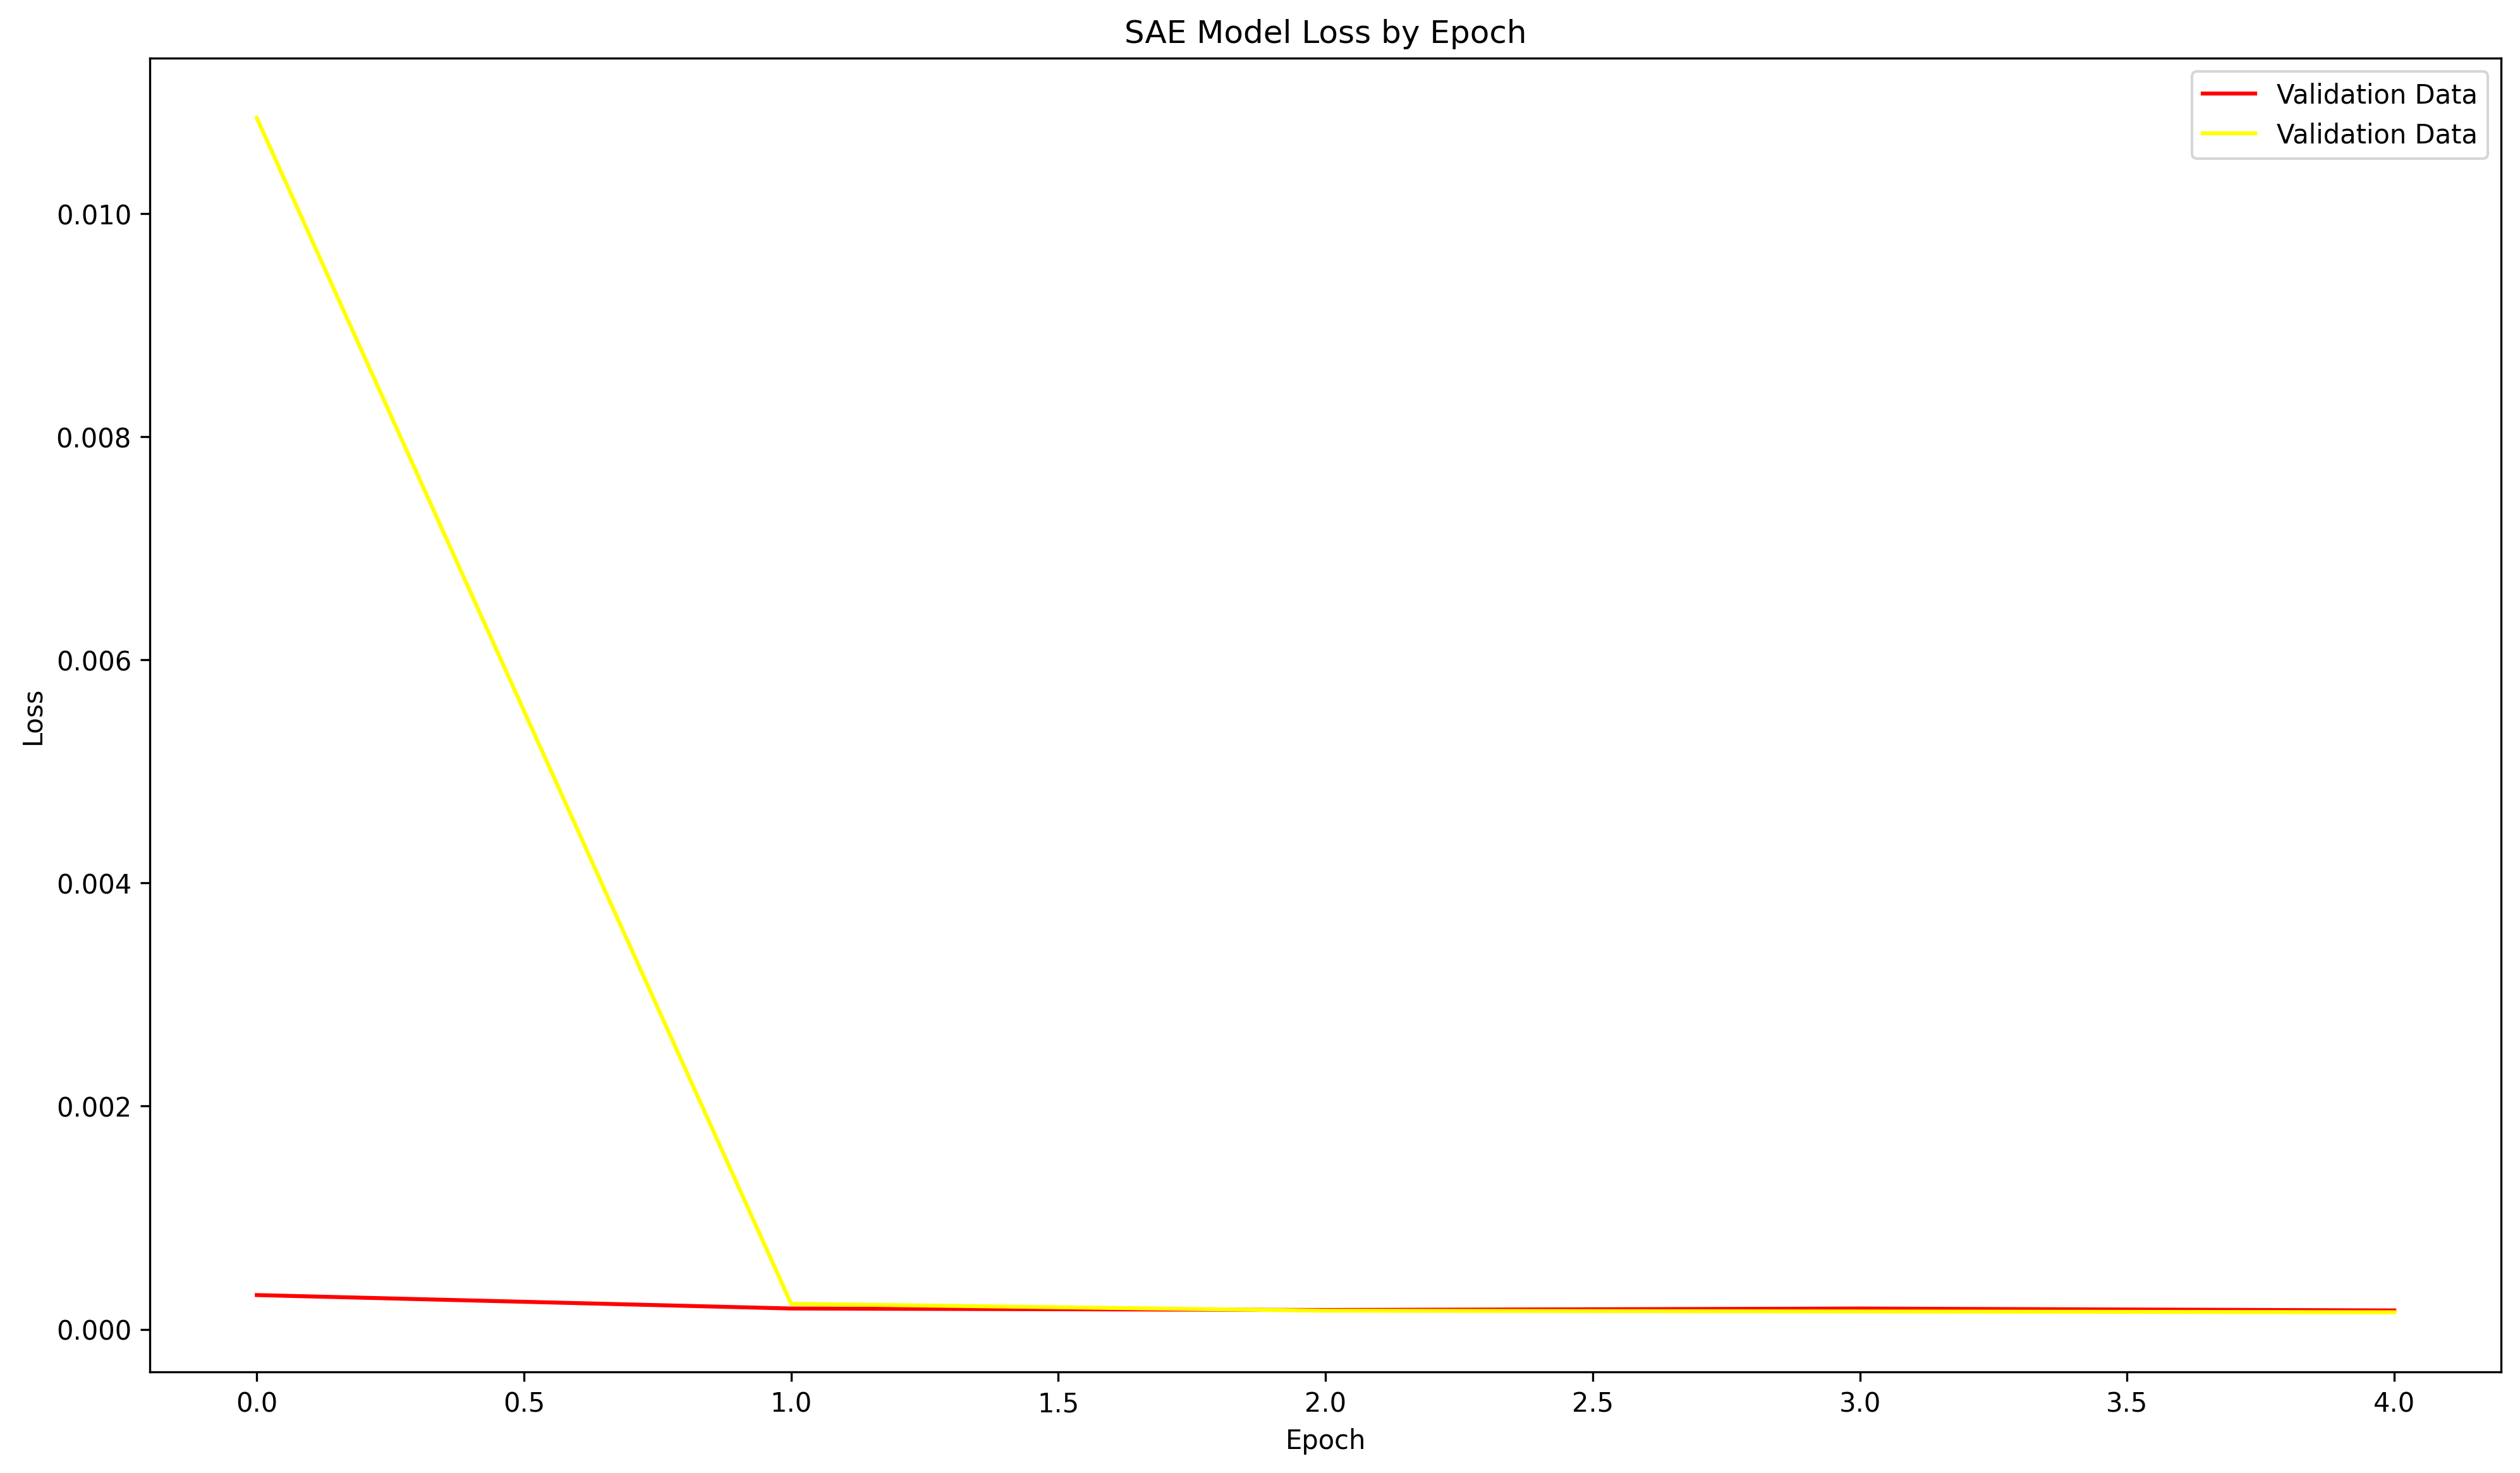

In [188]:
Sfig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='SAE Model Loss by Epoch', loc='center')
ax.plot(history['val_loss'], label='Validation Data', color='red')
ax.plot(history['loss'], label='Validation Data', color='yellow')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.legend()
plt.show()

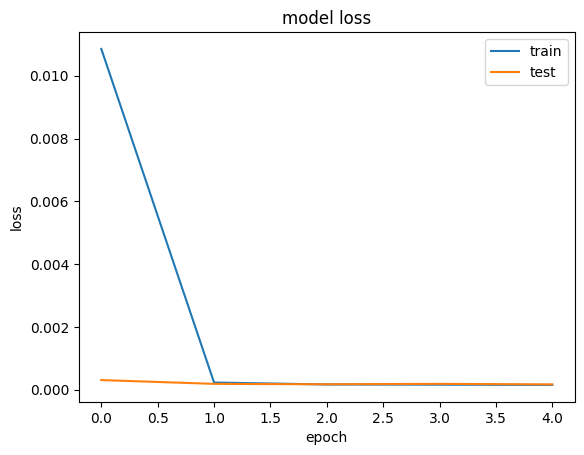

In [189]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [190]:
SAE_model.get_weights()

[array([[-0.0000000e+00,  9.6179348e-01,  7.9013442e-04, ...,
         -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
        [-0.0000000e+00,  1.2016725e-05, -0.0000000e+00, ...,
         -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
        [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
         -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
        ...,
        [-0.0000000e+00,  1.9746339e-02, -0.0000000e+00, ...,
         -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
        [ 2.0397504e-04, -0.0000000e+00,  1.6415361e-04, ...,
         -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
        [-0.0000000e+00, -0.0000000e+00,  1.1305821e-04, ...,
         -0.0000000e+00, -0.0000000e+00, -0.0000000e+00]], dtype=float32),
 array([-0.0000000e+00, -0.0000000e+00,  7.0759788e-04,  4.6145485e-04,
        -0.0000000e+00, -0.0000000e+00,  2.6859381e-04, -0.0000000e+00,
         3.8735228e-04, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
         1.8873068e-03, -0.0000000